# Assignment 5 - Reinforcement Learning

## Nathan Inkawhich
Netid:  nai2

### Blackjack

Your goal is to develop a reinforcement learning technique to learn the optimal policy for winning at blackjack. Here, we're going to modify the rules from traditional blackjack a bit in a way that corresponds to the game presented in Sutton and Barto's *Reinforcement Learning: An Introduction* (Chapter 5, example 5.1). A full implementation of the game is provided and usage examples are detailed in the class header below.

The rules of this modified version of the game of blackjack are as follows:

- Blackjack is a card game where the goal is to obtain cards that sum to as near as possible to 21 without going over.  We're playing against a fixed (autonomous) dealer.
- Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1, and we're refer to it as 'usable' at 11 (indicating that it could be used as a '1' if need be. This game is placed with a deck of cards sampled with replacement.
- The game starts with each (player and dealer) having one face up and one face down card.
- The player can request additional cards (hit, or action '1') until they decide to stop (stay, action '0') or exceed 21 (bust, the game ends and player loses).
- After the player stays, the dealer reveals their facedown card, and draws until their sum is 17 or greater. If the dealer goes bust the player wins. If neither player nor dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.  The reward for winning is +1, drawing is 0, and losing is -1.



You will accomplish three things:
1. Try your hand at this game of blackjack and see what your human reinforcement learning system is able to achieve
2. Evaluate a simple policy using Monte Carlo policy evaluation
3. Determine an optimal policy using Monte Carlo control

*This problem is adapted from David Silver's [excellent series on Reinforcement Learning](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html) at University College London*

## 1

### [10 points] Human reinforcement learning 

Using the code detailed below, play 50 hands of blackjack, and record your overall average reward. This will help you get accustomed with how the game works, the data structures involved with representing states, and what strategies are most effective.

In [1]:
import numpy as np

class Blackjack():
    """Simple blackjack environment adapted from OpenAI Gym:
        https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
    
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with a deck sampled with replacement.
    
    The game starts with each (player and dealer) having one face up and one
    face down card.
    
    The player can request additional cards (hit = 1) until they decide to stop
    (stay = 0) or exceed 21 (bust).
    
    After the player stays, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    
    The observation is a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (1998).
    
    http://incompleteideas.net/sutton/book/the-book.html
    
    Usage: 
        Initialize the class:
            game = Blackjack()
        
        Deal the cards:
            game.deal()
            
             (14, 3, False)
             
            This is the agent's observation of the state of the game:
            The first value is the sum of cards in your hand (14 in this case)
            The second is the visible card in the dealer's hand (3 in this case)
            The Boolean is a flag (False in this case) to indicate whether or 
                not you have a usable Ace
            (Note: if you have a usable ace, the sum will treat the ace as a 
                value of '11' - this is the case if this Boolean flag is "true")
            
        Take an action: Hit (1) or stay (0)
        
            Take a hit: game.step(1)
            To Stay:    game.step(0)
            
        The output summarizes the game status:
            
            ((15, 3, False), 0, False)
            
            The first tuple (15, 3, False), is the agent's observation of the
            state of the game as described above.
            The second value (0) indicates the rewards
            The third value (False) indicates whether the game is finished
    """
    
    def __init__(self):
        # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
        self.deck   = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.dealer = []
        self.player = []
        self.deal()

    def step(self, action):
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if self.is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stay: play out the dealers hand, and score
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            reward = self.cmp(self.score(self.player), self.score(self.dealer))
        return self._get_obs(), reward, done

    def _get_obs(self):
        return (self.sum_hand(self.player), self.dealer[0], self.usable_ace(self.player))

    def deal(self):
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        return self._get_obs()
    
    #------------------------------------------
    # Other helper functions
    #------------------------------------------
    def cmp(self, a, b):
        return float(a > b) - float(a < b)
    
    def draw_card(self):
        return int(np.random.choice(self.deck))
    
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]
    
    def usable_ace(self,hand):  # Does this hand have a usable ace?
        return 1 in hand and sum(hand) + 10 <= 21
    
    def sum_hand(self,hand):  # Return current hand total
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)
    
    def is_bust(self,hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21
    
    def score(self,hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)

Here's an example of how it works to get you started:

In [2]:
import numpy as np

# Initialize the class:
game = Blackjack()

win_count = 0
draw_count = 0
num_games = 50
# Play 50 games
for i in range(1,num_games+1):
    
    # Deal the cards:
    s0 = game.deal()
    print "\n***************\nStart of game {}: {}".format(i,s0) 
    
    while True:
        action = input("Enter action <hit=1, stay=0>: ")
        # Take an action: Hit = 1 or stay = 0.
        s1 = game.step(action)
        print "State of world: ",s1 
        if s1[2] == True:
            if s1[1] == 1:
                print("WIN!")
                win_count += 1
            elif s1[1] == 0:
                print("DRAW")
                draw_count += 1
            else:
                print("LOSE!")
            break

print "\n********************************"
print "GAME SUMMARY"
print "********************************"
print "Win Count: ",win_count
print "Draw Count: ",draw_count
print "Lose Count: ",num_games - (draw_count+win_count)
print "Total Games: ", num_games
print "% Win = ",win_count/float(num_games)
            




***************
Start of game 1: (19, 10, True)
Enter action <hit=1, stay=0>: 0
State of world:  ((19, 10, True), 1.0, True)
WIN!

***************
Start of game 2: (18, 10, False)
Enter action <hit=1, stay=0>: 0
State of world:  ((18, 10, False), -1.0, True)
LOSE!

***************
Start of game 3: (16, 3, False)
Enter action <hit=1, stay=0>: 1
State of world:  ((17, 3, False), 0, False)
Enter action <hit=1, stay=0>: 1
State of world:  ((27, 3, False), -1, True)
LOSE!

***************
Start of game 4: (13, 10, False)
Enter action <hit=1, stay=0>: 1
State of world:  ((14, 10, False), 0, False)
Enter action <hit=1, stay=0>: 1
State of world:  ((24, 10, False), -1, True)
LOSE!

***************
Start of game 5: (9, 6, False)
Enter action <hit=1, stay=0>: 1
State of world:  ((15, 6, False), 0, False)
Enter action <hit=1, stay=0>: 1
State of world:  ((25, 6, False), -1, True)
LOSE!

***************
Start of game 6: (14, 3, False)
Enter action <hit=1, stay=0>: 1
State of world:  ((20, 3, Fals

**ANSWER**

From above, the game summary is as follows: 

- Total Games = 50
- Win Count = 16
- Draw Count = 3
- Lose Count = 31
- % Win = $\frac{16}{50} = 32\%$
- Average Reward = $\frac{16*1 + 3*0 + 31*-1}{50} = -0.3$

## 2

### [40 points] Perform Monte Carlo Policy Evaluation

Thinking that you want to make your millions playing blackjack, you decide to test out a policy for playing this game. Your idea is an aggressive strategy: always hit unless the total of your cards adds up to 20 or 21, in which case you stay.

**(a)** Use Monte Carlo policy evaluation to evaluate the expected returns from each state. Create plots for these similar to Sutton and Barto, Figure 5.1 where you plot the expected returns for each state. In this case create 2 plots:
1. When you have a useable ace, plot the state space with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the 'RdBu' matplotlib colormap and `imshow` to plot the value of each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's card). Do this for for 10,000 episodes.
2. Repeat (1) for the states without a usable ace.
3. Repeat (1) for the case of 500,000 episodes.
4. Repeat (2) for the case of 500,000 episodes.

**(b)** Show a plot of the overall average reward per episode vs the number of episodes. For both the 10,000 episode case and the 500,000 episode case, record the overall average reward for this policy and report that value. 

**ANSWER**

In [103]:
########################################
# (A)
########################################
from collections import defaultdict
import matplotlib.pyplot as plt

############################
# Policy Fxn

# Define the policy function we will use
def policy_fxn(state):
    # state = (sum of player cards, dealer's visible card, have usable Ace)
    
    # Extract current sum from state
    sum_cards,_,_ = state
    
    # if sum < 20: HIT(1); else: STAY(0)
    if sum_cards < 20:
        return 1
    else:
        return 0
    
############################
# Prediction Fxn 

def Monte_Carlo_Prediction(game, policy, num_episodes):

    ##### Initialize data structures before simulation
    
    # V: arbitrary state value function. A container with an entry for each state
    #   as states are visited during the episode this container will be updated
    V = defaultdict(float)
    # Returns: a container to store the returns for each state
    Returns = defaultdict(float)
    # Returns_cnt: a container to store the number of times the state was visited
    #   Used when averaging rewards
    Returns_cnt = defaultdict(float)
    # For saving average reward per episode
    average_reward_per_episode = []
    
    total_reward = 0
    total_episodes = 0
    
    ##### Main Prediction Algo
    for episode_num in range(1, num_episodes+1):

        ### Step 1: Generate Episode

        # Initialize a fresh game
        #   Return of game.deal: (16, 10, False) i.e. (player_sum, dealer_card, usable_Ace)
        curr_state = game.deal()

        # Generate an episode using the policy fxn, and save states along the way
        #   An episode is one hand of black jack, from deal to end
        episode = []
        
        counter = 0
        while True:

            # Determine action based on current policy function
            action = policy(curr_state)

            # Return of game.step: ((16, 10, False), 0, False)
            #   i.e. ((player_sum, dealer_card, usable_Ace), rewards, game_finished)
            next_state,reward,game_over = game.step(action)

            # Update counters for average reward per episode stat
            #total_episode_reward += reward
            #counter += 1
            
            # Save the state and reward info
            episode.append((curr_state, reward))

            # Check for end of episode
            if game_over:
                total_reward += reward
                break

            # If game not over, continue playing from where we are now
            curr_state = next_state
        
        total_episodes += 1
        # Save average reward for this episode
        average_reward_per_episode.append(total_reward/float(total_episodes))
            
        ### Step 2: Update Values and Returns
        # Dont need to worry about recurring states within an episode
        
        # For each state appearing in the episode:
        for i in range(len(episode)):

            # Extract info from entry
            state,reward = episode[i]

            # G = return following the first occurrence of s
            #   Sum all rewards from here to end
            G = 0
            for j in range(i,len(episode)):
                G += episode[j][1]

            # Append G to Returns[s]
            Returns[state] += G
            # Update Returns_cnt[s] so we can average reward over # of visits to state
            Returns_cnt[state] += 1

            # V[s] = average(Returns[s])
            V[state] = Returns[state]/Returns_cnt[state]
        
    return V,average_reward_per_episode

####### Run the predictions

# Initialize a Blackjack game to play
bjack_game = Blackjack()

print "Running 10k prediction..."
V_10k, avg_reward_10k = Monte_Carlo_Prediction(bjack_game, policy_fxn, 10000)
print "Running 500k prediction..."
V_500k, avg_reward_500k = Monte_Carlo_Prediction(bjack_game, policy_fxn, 500000)
print "Done running predictions..."


Running 10k prediction...
Running 500k prediction...
Done running predictions...


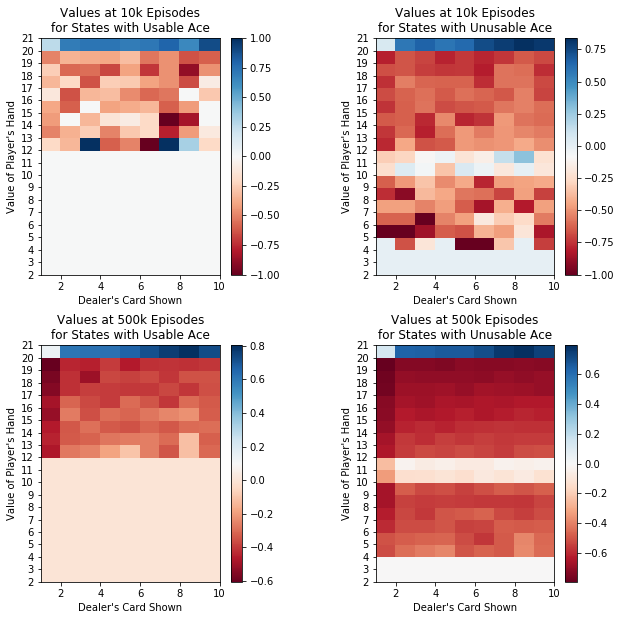

In [104]:
'''
(a) Use Monte Carlo policy evaluation to evaluate the expected returns from each state. 
Create plots for these similar to Sutton and Barto, Figure 5.1 where you plot the expected 
returns for each state. In this case create 2 plots:

(1) When you have a useable ace, plot the state space with the dealer's card on the x-axis, 
  and the player's sum on the y-axis, and use the 'RdBu' matplotlib colormap and imshow 
  to plot the value of each state under the policy described above. The domain of your 
  x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 
  10 for the dealer's card). Do this for for 10,000 episodes.
  Repeat (1) for the states without a usable ace.
  Repeat (1) for the case of 500,000 episodes.
  Repeat (2) for the case of 500,000 episodes.
'''

###########################
# Plotting

# Dealers card showing
x = np.arange(1, 11, 1)
# Sum of cards in player hand
y = np.arange(2, 22, 1)
# Create mesh grid of all possible x,y coords
X, Y = np.meshgrid(x, y)

# Grab the value in V for each x,y coordinate for 'usable_Ace = True'
z10k_usable = np.array([V_10k[(y,x,True)] for (x,y) in zip(np.ravel(X), np.ravel(Y))])
Z10k_usable = z10k_usable.reshape(X.shape)

# Grab the value in V for each x,y coordinate for 'usable_Ace = False'
z10k_unusable = np.array([V_10k[(y,x,False)] for (x,y) in zip(np.ravel(X), np.ravel(Y))])
Z10k_unusable = z10k_unusable.reshape(X.shape)

# Grab the value in V for each x,y coordinate for 'usable_Ace = True'
z500k_usable = np.array([V_500k[(y,x,True)] for (x,y) in zip(np.ravel(X), np.ravel(Y))])
Z500k_usable = z500k_usable.reshape(X.shape)

# Grab the value in V for each x,y coordinate for 'usable_Ace = False'
z500k_unusable = np.array([V_500k[(y,x,False)] for (x,y) in zip(np.ravel(X), np.ravel(Y))])
Z500k_unusable = z500k_unusable.reshape(X.shape)

plt.figure(figsize=(10,10))

###### Plotting 10k prediction results

plt.subplot(2,2,1)
plt.title("Values at 10k Episodes\nfor States with Usable Ace")
plt.xlabel("Dealer's Card Shown")
plt.ylabel("Value of Player's Hand")
plt.yticks(np.arange(2, 22, 1))
plt.pcolor(X,Y,Z10k_usable, cmap='RdBu')
plt.colorbar()

plt.subplot(2,2,2)
plt.title("Values at 10k Episodes\nfor States with Unusable Ace")
plt.xlabel("Dealer's Card Shown")
plt.ylabel("Value of Player's Hand")
plt.yticks(np.arange(2, 22, 1))
plt.pcolor(X,Y,Z10k_unusable, cmap='RdBu')
plt.colorbar()

###### Plotting 500k prediction results

plt.subplot(2,2,3)
plt.title("Values at 500k Episodes\nfor States with Usable Ace")
plt.xlabel("Dealer's Card Shown")
plt.ylabel("Value of Player's Hand")
plt.yticks(np.arange(2, 22, 1))
plt.pcolor(X,Y,Z500k_usable, cmap='RdBu')
plt.colorbar()

plt.subplot(2,2,4)
plt.title("Values at 500k Episodes\nfor States with Unusable Ace")
plt.xlabel("Dealer's Card Shown")
plt.ylabel("Value of Player's Hand")
plt.yticks(np.arange(2, 22, 1))
plt.pcolor(X,Y,Z500k_unusable, cmap='RdBu')
plt.colorbar()

plt.subplots_adjust(wspace=.5, hspace=.3)
plt.show()

**(A)**

The above plots show the state space, i.e. state value function $V$ for all combinations of state. The top row of plots show the state after 10k episodes and the bottom row shows the state space after 500k episodes. The columns denote whether or not the hand has a usable ace. It is evident that at 10k iterations, the values have not settled because not enough episodes have passed. However at 500k iterations, the values in $V$ have converged. 

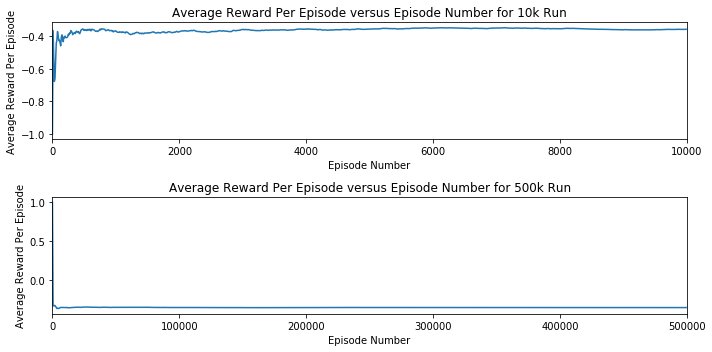

Overall Average Reward (10k Run):  -0.360948732302
Overall Average Reward (500k Run):  -0.351250535626


In [105]:
########################################
# (B)
########################################
#avg_reward_10k,avg_reward_500k

plt.figure(figsize=(10,5))

##### Plotting average reward per episode for 10k run
plt.subplot(2,1,1)
plt.title("Average Reward Per Episode versus Episode Number for 10k Run")
plt.ylabel("Average Reward Per Episode")
plt.xlabel("Episode Number")
plt.xlim((0, 10000))
plt.plot(range(0,len(avg_reward_10k),10), [avg_reward_10k[i] for i in range(0,len(avg_reward_10k),10)])

plt.subplot(2,1,2)
plt.title("Average Reward Per Episode versus Episode Number for 500k Run")
plt.ylabel("Average Reward Per Episode")
plt.xlabel("Episode Number")
plt.xlim((0, 500000))
plt.plot(range(0,len(avg_reward_500k),500), [avg_reward_500k[i] for i in range(0,len(avg_reward_500k),500)])

plt.tight_layout()
plt.show()

# Calculate overall average rewards for 10k and 500k runs
# for 10k
overall_10k = np.sum(np.array(avg_reward_10k))/float(len(avg_reward_10k))
overall_500k = np.sum(np.array(avg_reward_500k))/float(len(avg_reward_500k))
print "Overall Average Reward (10k Run): ", overall_10k
print "Overall Average Reward (500k Run): ", overall_500k

**(B)**

The above plots show the overall average reward per episode vs the number of episodes for both the 10k episode run (top) and 500k episode run (bottom). As is clear, the policy is fixed, i.e. no learning is happening, so the average reward is largely static. We can summarize these plots in a scalar value each as the overall average reward for this policy at the 10k at 500k marks. Both are very similar, the 10k episode average reward is -0.36, and the 500k average reward is -0.35.

## 3

### [40 points] Perform Monte Carlo Control

**(a)** Using Monte Carlo Control through policy iteration, estimate the optimal policy for playing our modified blackjack game to maximize rewards. 

In doing this, use the following assumptions:
1. Initialize the value function and the state value function to all zeros
2. Keep a running tally of the number of times the agent visited each state and chose an action. N(s_t,a_t) is the number of times action $a$ has been selected from state $s$. You'll need this to compute the running average. You can implement an online average as: $\bar{x}_{t} = \frac{1}{N}x_t + \frac{N-1}{N}\bar{x}_{t-1}$ 
3. Use an $\epsilon$-greedy exploration strategy with $\epsilon_t = \frac{N_0}{N_0 + N(s_t)}$, where we define $N_0 = 100$. Vary $N_0$ as needed.

Show your result by plotting the optimal value function: $V^*(s) = max_a Q^*(s,a)$ and the optimal policy $\pi^*(s)$. Create plots for these similar to Sutton and Barto, Figure 5.2 in the new draft edition, or 5.5 in the original edition. Your results SHOULD be very similar to the plots in that text. For these plots include:
1. When you have a useable ace, plot the state space with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the 'RdBu' matplotlib colormap and `imshow` to plot the value of each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's visible card).
2. Repeat (1) for the states without a usable ace.
3. A plot of the optimal policy $\pi^*(s)$ for the states with a usable ace (this plot could be an imshow plot with binary values).
4. A plot of the optimal policy $\pi^*(s)$ for the states without a usable ace (this plot could be an imshow plot with binary values).

**(b)** Show a plot of the overall average reward per episode vs the number of episodes. What is the average reward your control strategy was able to achieve?

*Note: convergence of this algorithm is extremely slow. You may need to let this run a few million episodes before the policy starts to converge. You're not expected to get E* 

**ANSWER**

In [107]:
########################################
# (A)
########################################
from collections import defaultdict
import matplotlib.pyplot as plt
import random

############################
# Control Fxn 

# Define the policy function we will use
def policy_fxn(policy, state, epsilon):
    
    # Introduce some uncertainty based on epsilon
    # state = (sum of player cards, dealer's visible card, have usable Ace)
    
    # Look up the best policy for this state
    a_best = policy[state]
    a_other = 0 if a_best == 1 else 1
    
    # Generate a random number in [0,1]
    num = random.uniform(0, 1)
    # check for (1-epsilon) case where we choose to EXPLORE
    if num >= epsilon:
        return a_other
    # Most of the time choose to EXPLOIT
    else:
        return a_best
    
def Monte_Carlo_Control(game, policy, num_iters):

    ##### Initialize data structures before simulation
    
    # Q: arbitrary action value function. A container with an entry for each state,
    #   action pair. As states are visited and actions are taken during the episode 
    #   this container will be updated
    Q = defaultdict(float)
    # Returns: a container to store the returns for each state,action
    Returns = defaultdict(float)
    # Returns_cnt: a container to store the number of times the state,action was taken
    #   Used when averaging rewards
    Returns_cnt = defaultdict(float)
    # Policy: There is one policy for each possible state. When you get to a state
    #   look up the perscribed policy from this structure.
    Policy = defaultdict(float)
    # For saving average reward per episode
    average_reward_per_episode = []
    running_overall_average_reward = []
    total_reward = 0
    episode_counter = 0
    
    ##### Control Algo
    for it in range(1, num_iters+1):

        ### Step 1: Generate Episode

        # Initialize a fresh game
        #   Return of game.deal: (16, 10, False) i.e. (player_sum, dealer_card, usable_Ace)
        curr_state = game.deal()

        # Generate an episode using the policy fxn, and save state,actions along the way
        #   An episode is one hand of black jack, from deal to end
        episode = []
        total_episode_reward = 0
        counter = 0
        
        while True:

            # Determine action based on current policy function
            # Calculate eqsilon
            N_0 = 100.
            N_st = Returns_cnt[(curr_state,1)] + Returns_cnt[(curr_state,0)]
            eps = 1- N_0/(N_0 + N_st)
            action = policy(Policy, curr_state, eps)

            # Return of game.step: ((16, 10, False), 0, False)
            #   i.e. ((player_sum, dealer_card, usable_Ace), rewards, game_finished)
            next_state,reward,game_over = game.step(action)

            # Update counters for average reward per episode stat
            total_episode_reward += reward
            #total_reward += reward
            counter += 1
            
            # Save the state, reward, and action info so we can learn from our
            #   interactions with this environment
            episode.append((curr_state, reward, action))

            # Check for end of episode
            if game_over:
                total_reward += reward
                #print reward
                break

            # If game not over, continue playing from where we are now
            curr_state = next_state

        # Save average reward for this episode
        average_reward_per_episode.append(total_episode_reward/float(counter))
        episode_counter += 1
        running_overall_average_reward.append(total_reward/float(episode_counter))
        
        ### Step 2: Update Q(s,a) and Returns
        # Dont need to worry about recurring states within an episode
        
        # For each state,action pair appearing in the episode:
        for i in range(len(episode)):

            # Extract info from entry
            state,reward,action = episode[i]

            # G = return following the first occurrence of s,a
            #   i.e. Sum all rewards from here to end
            G = 0
            for j in range(i,len(episode)):
                G += episode[j][1]

            # Append G to Returns[s,a]
            Returns[(state,action)] += G
            # Update Returns_cnt[s,a] so we can average reward over # of visits to state,action
            Returns_cnt[(state,action)] += 1

            # Q[s,a] = average(Returns[s,a])
            Q[(state,action)] = Returns[(state,action)]/Returns_cnt[(state,action)]
            
        ### Step 3: Update policy according to new Q
        
        # For each state in the episode
        for i in range(len(episode)):
            state,_,_ = episode[i]
            # Find the best action for that state. 
            #   e.g. state = (12,3,False)
            #        Q(state, 1) = 4
            #        Q(state, 0) = -1
            #   So according to Q, the greedy best action to take when in state is 1 ('hit')
            a_hit = Q[(state,1)]
            a_stay = Q[(state,0)]
            a_best = 1 if a_hit > a_stay else 0
            Policy[state] = a_best
            
    return Q,Policy,average_reward_per_episode,running_overall_average_reward

# Initialize a Blackjack game to play
bjack_game = Blackjack()

print "Running MC Control..."
Q,policy,avg_reward,running_avg = Monte_Carlo_Control(bjack_game, policy_fxn, 6000000)
print "Done"



Running MC Control...
Done


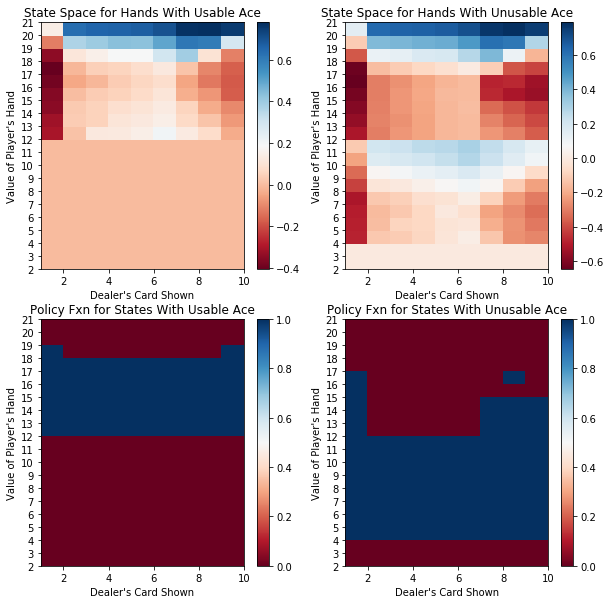

In [111]:
###########################
# Plotting

# Dealers card showing
x = np.arange(1, 11, 1)
# Sum of cards in player hand
y = np.arange(2, 22, 1)
# Create mesh grid of all possible x,y coords
X, Y = np.meshgrid(x, y)

# Grab the value in V for each x,y coordinate for 'usable_Ace = True'
q_usable = np.maximum(np.array([Q[((y,x,True),0)] for (x,y) in zip(np.ravel(X), np.ravel(Y))]) , np.array([Q[((y,x,True),1)] for (x,y) in zip(np.ravel(X), np.ravel(Y))])) 
Q_usable = q_usable.reshape(X.shape)

# Grab the value in V for each x,y coordinate for 'usable_Ace = False'
q_unusable = np.maximum(np.array([Q[((y,x,False),0)] for (x,y) in zip(np.ravel(X), np.ravel(Y))]) , np.array([Q[((y,x,False),1)] for (x,y) in zip(np.ravel(X), np.ravel(Y))])) 
Q_unusable = q_unusable.reshape(X.shape)

# Policy fxn for states with unusable ace
pol_unusable = np.array([policy_fxn(policy, (y,x,False), 1.1) for (x,y) in zip(np.ravel(X), np.ravel(Y))])
Policy_unusable = pol_unusable.reshape(X.shape)

# Policy fxn for states with usable ace
pol_usable = np.array([policy_fxn(policy, (y,x,True), 1.1) for (x,y) in zip(np.ravel(X), np.ravel(Y))])
Policy_usable = pol_usable.reshape(X.shape)


plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.title("State Space for Hands With Usable Ace")
plt.xlabel("Dealer's Card Shown")
plt.ylabel("Value of Player's Hand")
plt.yticks(np.arange(2, 22, 1))
plt.pcolor(X,Y,Q_usable, cmap='RdBu')
plt.colorbar()

plt.subplot(2,2,2)
plt.title("State Space for Hands With Unusable Ace")
plt.xlabel("Dealer's Card Shown")
plt.ylabel("Value of Player's Hand")
plt.yticks(np.arange(2, 22, 1))
plt.pcolor(X,Y,Q_unusable, cmap='RdBu')
plt.colorbar()

plt.subplot(2,2,3)
plt.title("Policy Fxn for States With Usable Ace")
plt.xlabel("Dealer's Card Shown")
plt.ylabel("Value of Player's Hand")
plt.yticks(np.arange(2, 22, 1))
plt.pcolor(X,Y,Policy_usable, cmap='RdBu')
plt.colorbar()

plt.subplot(2,2,4)
plt.title("Policy Fxn for States With Unusable Ace")
plt.xlabel("Dealer's Card Shown")
plt.ylabel("Value of Player's Hand")
plt.yticks(np.arange(2, 22, 1))
plt.pcolor(X,Y,Policy_unusable, cmap='RdBu')
plt.colorbar()

plt.show()

**(A)** 

The first-row plots show the state space, i.e. optimal value function: $V^*(s) = max_a Q^*(s,a)$ for the learned model, the first being for hands with a usable ace and the second for hands without a usable ace. A visual inspection shows that the state space is similar to the one shown in the Sutton and Barto Fig 5.5. The second-row plots show the policy function for the learned model, the first column showing the policy for hands with a usable ace and the second showing policy for hands without a usable ace. These plots also look very similar to Sutton and Barto Fig 5.5, however they are not identical. This is because the model has not completely converged to the optimal policy and the figure in the book shows the optimal policy. Note, the blue region is the *hit* region and the red is the *stay* region.

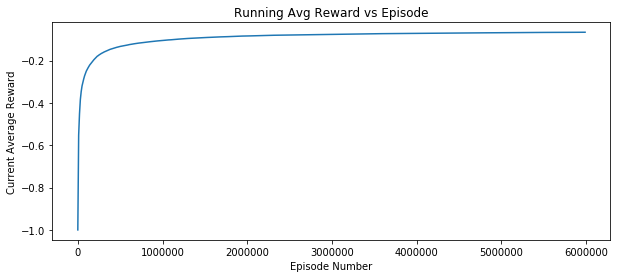

Overall Average Reward:  -0.0547042736111


In [110]:
########################################
# (B)
########################################

plt.figure(figsize=(10,4))
plt.title("Running Avg Reward vs Episode")
plt.ylabel("Current Average Reward")
plt.xlabel("Episode Number")
plt.plot(range(0,len(running_avg),10000), [running_avg[i] for i in range(0,len(running_avg),10000)])
#plt.plot(running_avg)
plt.show()

# Calculate overall average rewards for 10k and 500k runs
# for 10k
overall_avg_reward = np.sum(np.array(avg_reward))/float(len(avg_reward))
print "Overall Average Reward: ", overall_avg_reward

**(B)**

This plot shows the overall average reward per episode vs the number of episodes, and is the same information shown in section B of question 2. However, since this is an actively learning model, the plot shows a different trend. This plot shows that as more episodes pass, the average reward starts to converge to a negative value near zero. As discussed, the model is still converging at 6 Million episodes so the policy is not optimal but the overall average reward is -0.05, which is much better than my result or the naive policy shown in Q2.

## 4

### [10 points] Discuss your findings

Compare the performance of your human control policy, the naive policy from question 2, and the optimal control policy in question 3. 

**(a)** Which performs best? Why is this the case? 

**(b)** Could you have created a better policy if you knew the full Markov Decision Process for this environment? Why or why not?

**ANSWER**

**(a)** 

From the above three runs we have collected the following results. The average reward from **1** where I played for 50 hands is -0.3. The average reward from the fixed naive policy in question **2**, over the 500k iterations, is -0.35. And the average reward from question **3** where the RL agent was 'learning' from experience and actively adjusting the policy function is -0.05. From these results the most obvious take away is that I am a terrible black jack player, as I barely beat a very naive strategy. But, it is also clear that the result from question **3**, where we learn a nearly optimal strategy (as compared to the optimal result in the book) and our average reward is -0.05, is the best. The Monte Carlo control is better than the result in Q2 because the fixed policy from Q2 is suboptimal and no learning is happening. One may argue that the optimal control policy is better than my human policy only because it saw 6 Million episodes, whereas I only played for 50 episodes. I would be inclined to think that if a human played for 6 Million hands, they too would learn a near optimal strategy, however, that person may spend a lifetime playing where it only takes the computer a few minutes. Also, it is worth mentioning that the reason the result from Q3 is not optimal is because it had not completely converged in the 6 Million iterations, which is evident because consecutive runs yield similar but not identical results, and the plot from Q3-b show the average reward is still converging *slowly*.

**(b)** 

Yes, I could have created a better policy if I knew the full MDP because that would mean that I knew the exact interworkings of the environment rather that only learning from experience. With knowledge of the MDP we could simulate actions without actually taking them. Also, that knowledge would mean that we know the exact probability distributions involved with computing the optimal policy, whereas without knowledge of the MDP we effectively have to estimate the distributions which inherently leads to error.
